In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
import hashlib
import requests
from matplotlib import pyplot as plt
import tqdm as tqdm

In [2]:
# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [3]:
# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [3, 4]]  # which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Convert lists of NumPy arrays to single NumPy arrays before conversion to tensors
    go_envelope_np = np.array(go_envelope_condition)
    plan_np = np.array(plan_condition)
    muscle_np = np.array(muscle_condition)

    # Convert the single NumPy arrays to PyTorch tensors
    go_envelope_all.append(torch.tensor(go_envelope_np, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_np, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_np, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Print shapes
print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
print(f"Plan Tensor Shape: {plan_tensor.shape}")
print(f"Muscle Tensor Shape: {muscle_tensor.shape}")


Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


In [4]:
# Normalization and Standardization
def normalize_and_standardize(tensor):

    # Standardize: shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std

    return tensor

# Apply normalization and standardization to go_envelope_tensor and plan_tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = muscle_tensor

# Concatenate normalized tensors along the last dimension
X_train = torch.cat((normalized_go_envelope_tensor, normalized_plan_tensor), dim=2)
y_train = normalized_muscle_tensor

batch_size = 256  # You can adjust this based on your data size and memory constraints
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

Epoch 1, Loss: 0.9119714498519897
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  325347 KB |  569550 KB |    2681 MB |    2363 MB |
|       from large pool |    3996 KB |    3996 KB |       3 MB |       0 MB |
|       from small pool |  321351 KB |  565554 KB |    2677 MB |    2363 MB |
|---------------------------------------------------------------------------|
| Active memory         |  325347 KB |  569550 KB |    2681 MB |    2363 MB |
|       from large pool |    3

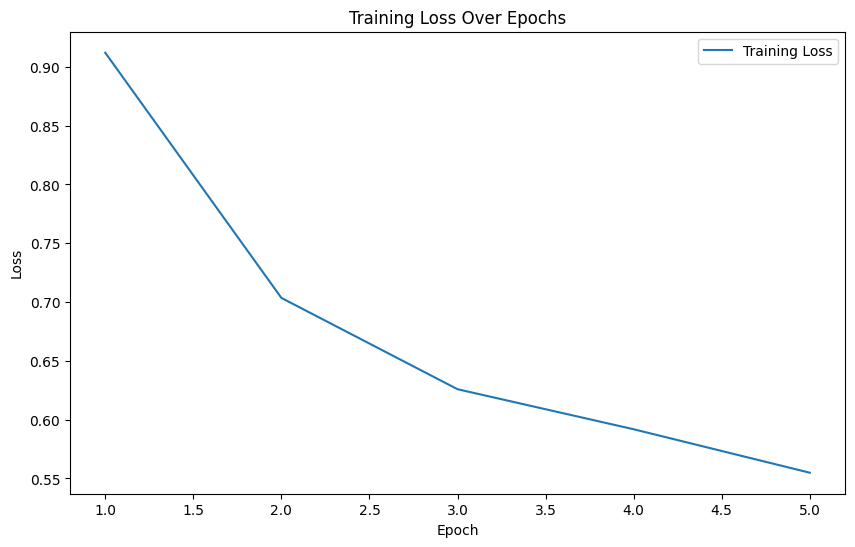

In [5]:
# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  # New linear layer

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
        
        self.hidden_activations = []    
        
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration    
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1)) 
        input_update = torch.matmul(self.B, x.transpose(0, 1))        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)    
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)    
        # Output calculation
        output = self.output_linear(firing_rate)    
        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()
        
        self.hidden_activations.append(hidden.clone())
        
        return output, hidden, firing_rate_reg, dynamic_reg

    def reset_activations(self):
        self.hidden_activations = []
        
    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-4  
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 5
epoch_losses = [] 

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)
hidden_states_for_plot = []
# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size).to(device) # Initialize hidden state with the current batch size
        optimizer.zero_grad()

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        for t in range(inputs.shape[1]):  # Iterate over time steps
            output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
            hidden_states_for_plot.append(h.detach().cpu().numpy())
            total_firing_rate_reg += firing_rate_reg
            total_dynamic_reg += dynamic_reg

        # Compute loss using the last output and include regularization terms
        loss = criterion(output, targets[:, -1, :])
        l2_reg = compute_l2_regularization(model.parameters(), alpha)
        rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size /num_conditions  # Average over time steps
        rj_reg = gamma * total_firing_rate_reg / inputs.shape[1] /num_conditions # Average over time steps
    
        total_loss = loss + l2_reg + rfr_reg + rj_reg

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
        running_loss += total_loss.item()

    avg_loss = running_loss / float(len(train_loader))
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

    print(torch.cuda.memory_summary(device=device, abbreviated=False))

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()



Epoch 1, Loss: 0.5332739353179932
Epoch 2, Loss: 0.2686775326728821
Epoch 3, Loss: 0.11221214383840561
Epoch 4, Loss: 0.0376897007226944
Epoch 5, Loss: 0.00768316350877285
Finished Training


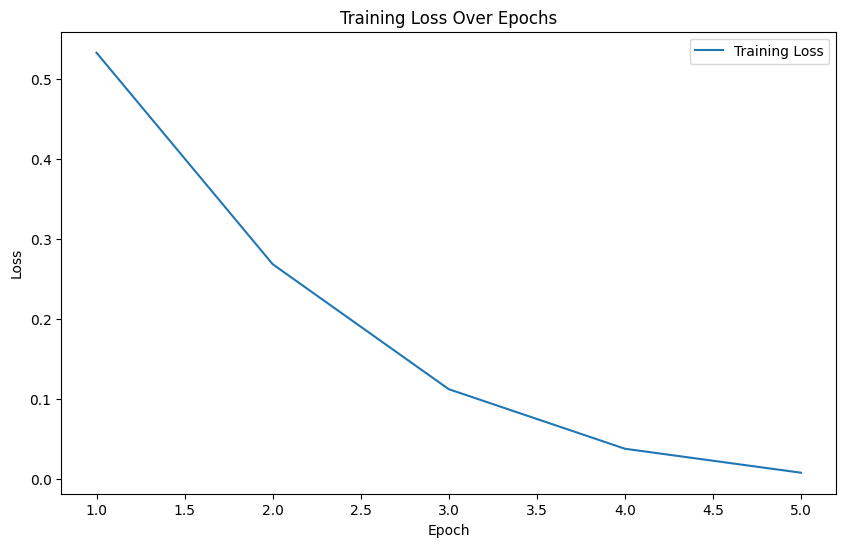

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Custom activation function (remains unchanged)
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0)

# ComplicatedRNN class
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization (unchanged)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity (unchanged)
        self.nonlinearity = rectified_tanh 
        
        self.hidden_activations = []    

    def forward(self, x, hidden):
        # Forward pass logic (same as SimpleRNN but without regularization terms)
        hidden_prev = hidden.clone()
        timestep = self.tau / 10

        firing_rate = self.nonlinearity(hidden)
        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))
        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)
    
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)
        output = self.output_linear(firing_rate)
        
        self.hidden_activations.append(hidden.clone())

        return output, hidden
        
    def reset_activations(self):
        self.hidden_activations = []
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Training loop
# Hyperparameters 
input_size = 16
hidden_size = 300
output_size = 2
g = 4
h_val = 1.0
num_epochs = 5
epoch_losses = []

# Device setup and model instantiation 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h_val)
complicated_model.to(device)
hidden_states_for_plot_cm = []

# Loss function and optimizer (no weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(complicated_model.parameters(), lr=0.001)

# Training loop (updated to remove regularization terms)
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        for t in range(inputs.shape[1]):
            output, h = complicated_model(inputs[:, t, :], h)
            hidden_states_for_plot_cm.append(h.detach().cpu().numpy())

        loss = criterion(output, targets[:, -1, :])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(complicated_model.parameters(), max_norm=1)
        optimizer.step()
    
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


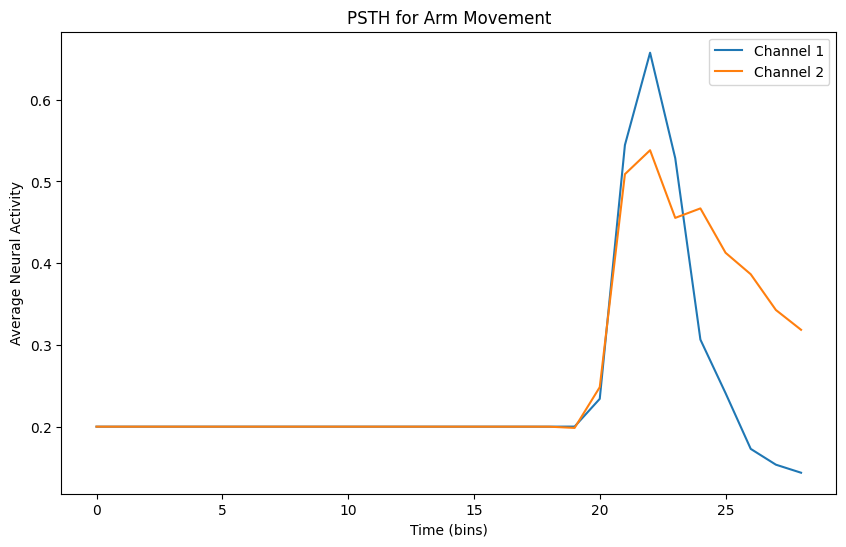

In [7]:
import matplotlib.pyplot as plt
import torch

def plot_psth(data, title, bin_size=10):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data
    :param title: a string for the plot title
    :param bin_size: size of time bins for averaging
    """
    # Averaging neural activity across trials for each time bin
    mean_data = data.mean(dim=0)  # Mean across trials
    n_bins = mean_data.shape[0] // bin_size

    # Prepare the data for plotting
    binned_data = mean_data.unfold(0, bin_size, bin_size).mean(dim=2)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(data.shape[2]):  # Iterate over each channel/neuron
        plt.plot(binned_data[:, i], label=f'Channel {i+1}')
    plt.xlabel('Time (bins)')
    plt.ylabel('Average Neural Activity')
    plt.title(title)
    plt.legend()
    plt.show()

# Example Usage
plot_psth(normalized_muscle_tensor, "PSTH for Arm Movement")


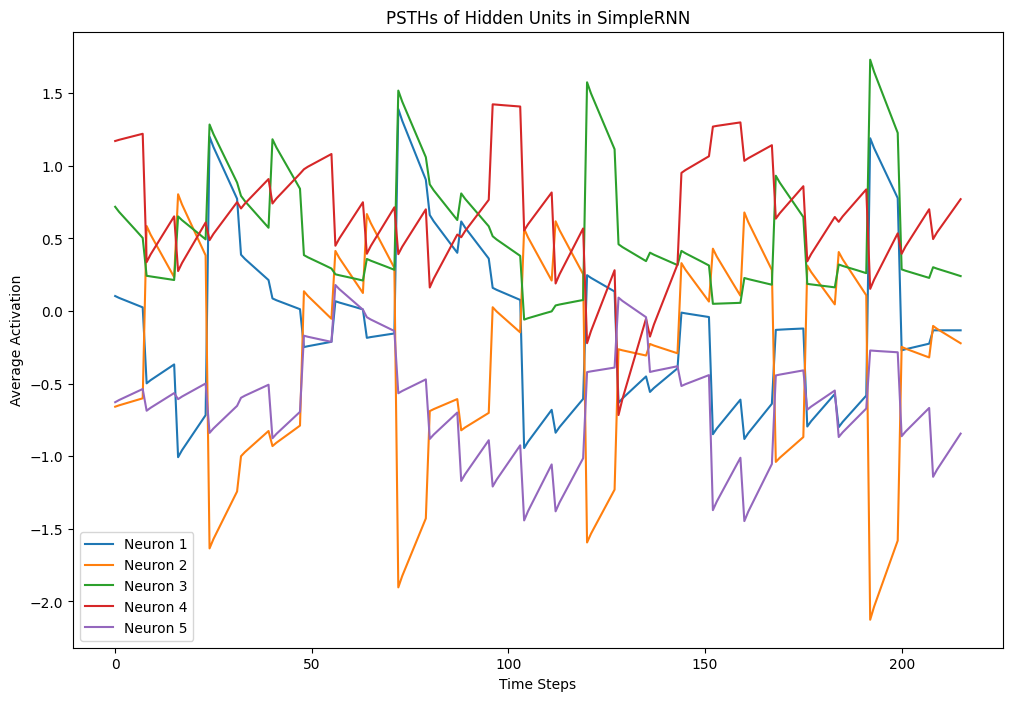

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Convert list of numpy arrays to a single numpy array
hidden_states = np.array(hidden_states_for_plot)

# Calculate the mean across all batches for each time step
# Assuming hidden_states.shape is [num_samples, num_time_steps, hidden_size]
mean_activations = np.mean(hidden_states, axis=0)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  # Adjust this number as needed
time_steps = mean_activations.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states.shape[2])):
    plt.plot(range(time_steps), mean_activations[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in SimpleRNN')
plt.legend()
plt.show()


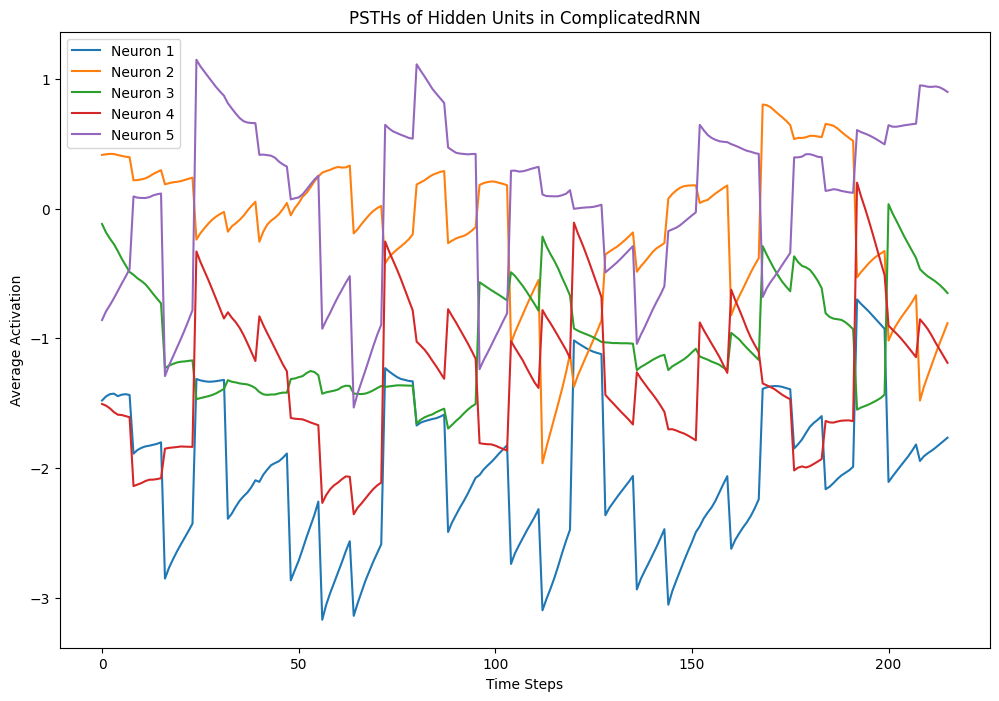

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Convert list of numpy arrays to a single numpy array
hidden_states_cm = np.array(hidden_states_for_plot_cm)

# Calculate the mean across all batches for each time step
# Assuming hidden_states.shape is [num_samples, num_time_steps, hidden_size]
mean_activations_cm = np.mean(hidden_states_cm, axis=0)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  # Adjust this number as needed
time_steps_cm = mean_activations_cm.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states_cm.shape[2])):
    plt.plot(range(time_steps), mean_activations_cm[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in ComplicatedRNN')
plt.legend()
plt.show()


Perturbation strength: 0.0001, Mean Error: 0.0019111933652311563
Perturbation strength: 0.001, Mean Error: 0.0019115356262773275
Perturbation strength: 0.01, Mean Error: 0.001916350331157446
Perturbation strength: 0.1, Mean Error: 0.0018694807076826692
Perturbation strength: 1, Mean Error: 0.008114849217236042
Perturbation strength: 0.0001, Mean Error: 0.012217656709253788
Perturbation strength: 0.001, Mean Error: 0.012217404320836067
Perturbation strength: 0.01, Mean Error: 0.01223879773169756
Perturbation strength: 0.1, Mean Error: 0.012463938444852829
Perturbation strength: 1, Mean Error: 0.016344280913472176


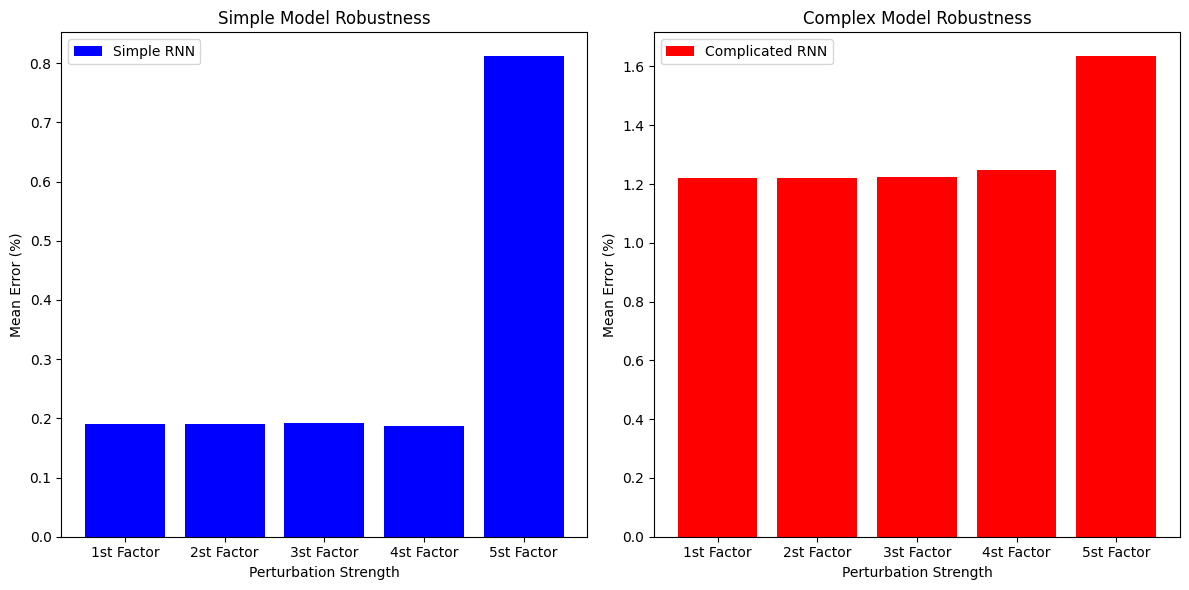

In [10]:
import torch
import numpy as np

def perturb_inputs(model, inputs, perturbation_strength):
    # Perturb the inputs by adding random noise scaled by the perturbation strength
    noise = torch.randn_like(inputs) * perturbation_strength
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_errors = []

    for strength in perturbation_strengths:
        batch_errors = []  # Store errors for each batch in the test_loader
        
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
            
            perturbed_inputs = perturb_inputs(model, inputs, strength)  # Perturb inputs here

            for t in range(inputs.shape[1]):  # Iterate over time steps
                model_output = model(perturbed_inputs[:, t, :], h)
                if len(model_output) == 4:  # If the model returns 4 outputs, unpack all (simple model)
                    output, h, _, _ = model_output
                else:  # If the model returns 2 outputs, unpack accordingly (complicated model)
                    output, h = model_output
            
            # Compute loss for the entire sequence (last output)
            loss = criterion(output, targets[:, -1, :]).item()
            batch_errors.append(loss)  # Append the loss of this batch
        
        mean_error = np.mean(batch_errors)  # Calculate mean error for this perturbation strength
        perturbation_errors.append(mean_error)
        print(f'Perturbation strength: {strength}, Mean Error: {mean_error}')
    
    return perturbation_errors

perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]
simple_model_errors = test_perturbed_inputs(model, perturbation_strengths, train_loader, criterion, device)
complex_model_errors = test_perturbed_inputs(complicated_model, perturbation_strengths, train_loader, criterion, device)

import matplotlib.pyplot as plt

# Convert errors to percentages 
simple_model_errors_percent = [error * 100 for error in simple_model_errors]
complex_model_errors_percent = [error * 100 for error in complex_model_errors]

# Generate a list of labels for the x-axis
x_labels = [f'{i+1}st Factor' for i in range(len(perturbation_strengths))]

# Plotting
plt.figure(figsize=(12, 6))

# Subplot for the simple model
plt.subplot(1, 2, 1)
plt.bar(x_labels, simple_model_errors_percent, color='blue', label='Simple RNN')
plt.xlabel('Perturbation Strength')
plt.ylabel('Mean Error (%)')
plt.title('Simple Model Robustness')
plt.legend()

# Subplot for the complex model
plt.subplot(1, 2, 2)
plt.bar(x_labels, complex_model_errors_percent, color='red', label='Complicated RNN')
plt.xlabel('Perturbation Strength')
plt.ylabel('Mean Error (%)')
plt.title('Complex Model Robustness')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


Perturbation strength: 0.0001, Mean Error: 0.0019039064645767212
Perturbation strength: 0.001, Mean Error: 0.0019338170532137156
Perturbation strength: 0.01, Mean Error: 0.004264007788151503
Perturbation strength: 0.1, Mean Error: 0.010210518725216389
Perturbation strength: 1, Mean Error: 0.06706734746694565
Perturbation strength: 0.0001, Mean Error: 0.012118489481508732
Perturbation strength: 0.001, Mean Error: 0.011956489644944668
Perturbation strength: 0.01, Mean Error: 0.012548867613077164
Perturbation strength: 0.1, Mean Error: 0.024771464988589287
Perturbation strength: 1, Mean Error: 0.15414609014987946


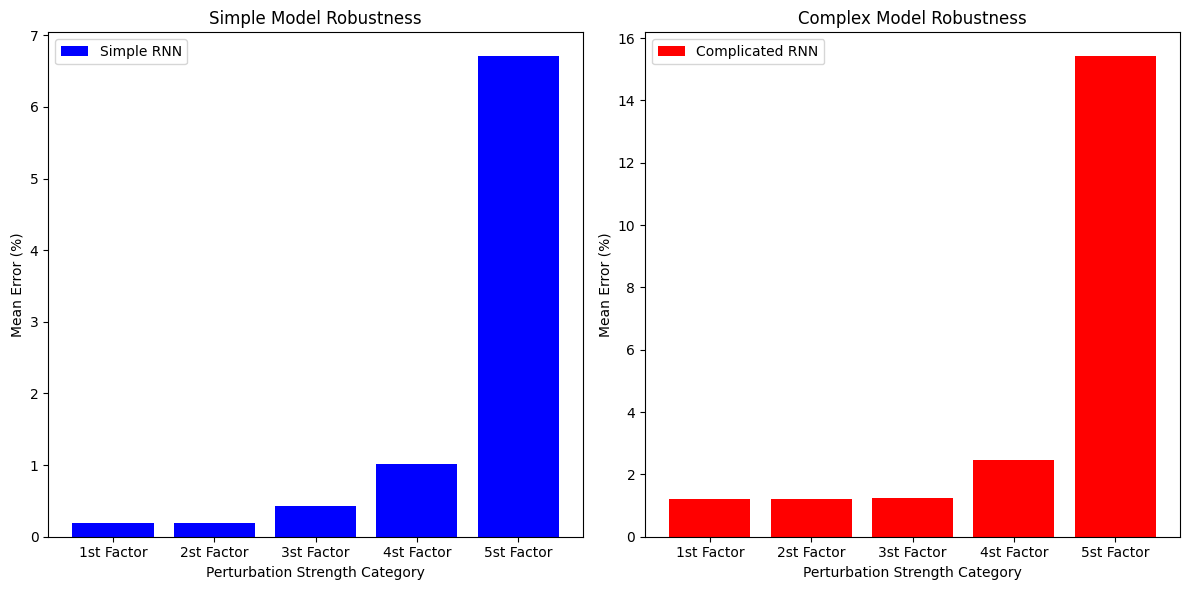

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.backends.mps
from torch.utils.data import DataLoader

# Assuming train_loader is defined elsewhere and is a DataLoader instance
# Assuming the models are instances of SimpleRNN or similar

def perturb_recurrent_weights(model, perturbation_strength):
    # Perturb the recurrent weight matrix J by adding Gaussian noise
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_errors = []
    original_weights = model.J.data.clone()  # Save the original weights

    for strength in perturbation_strengths:
        batch_errors = []  # Store errors for each batch in the test_loader
        # Perturb the recurrent weights of the model
        perturbed_weights = perturb_recurrent_weights(model, strength)
        model.J.data = perturbed_weights.data

        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
            
            for t in range(inputs.shape[1]):  # Iterate over time steps
                model_output = model(inputs[:, t, :], h)
                if len(model_output) == 4:  # If the model returns 4 outputs, unpack all (simple model)
                    output, h, _, _ = model_output
                else:  # If the model returns 2 outputs, unpack accordingly (complicated model)
                    output, h = model_output
            
            # Compute loss for the entire sequence (last output)
            loss = criterion(output, targets[:, -1, :]).item()
            batch_errors.append(loss)  # Append the loss of this batch
        
        # Restore the original weights before the next iteration
        model.J.data = original_weights.data
        
        mean_error = np.mean(batch_errors)  # Calculate mean error for this perturbation strength
        perturbation_errors.append(mean_error)
        print(f'Perturbation strength: {strength}, Mean Error: {mean_error}')
    
    return perturbation_errors

# Define your perturbation strengths
perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]

# Get errors for simple and complex models
simple_model_structural_errors = test_perturbed_structure(model, perturbation_strengths, train_loader, criterion, device)
complex_model_structural_errors = test_perturbed_structure(complicated_model, perturbation_strengths, train_loader, criterion, device)

# Convert errors to percentages 
simple_model_errors_percent = [error * 100 for error in simple_model_structural_errors]
complex_model_errors_percent = [error * 100 for error in complex_model_structural_errors]

# Generate a list of labels for the x-axis
x_labels = [f'{i+1}st Factor' for i in range(len(perturbation_strengths))]

plt.figure(figsize=(12, 6))

# For the simple model
plt.subplot(1, 2, 1)
plt.bar(x_labels, simple_model_errors_percent, color='blue', label='Simple RNN')
plt.xlabel('Perturbation Strength Category')
plt.ylabel('Mean Error (%)')
plt.title('Simple Model Robustness')
plt.legend()

# For the complex model
plt.subplot(1, 2, 2)
plt.bar(x_labels, complex_model_errors_percent, color='red', label='Complicated RNN')
plt.xlabel('Perturbation Strength Category')
plt.ylabel('Mean Error (%)')
plt.title('Complex Model Robustness')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()